# COMP-4360 - Machine Learning - Assignment 1 - Project

## Instructions

| Date set     | Hand-in date |
|------------------|-----------------------------------|
|6 October 2022  | **23 October 2022** |



Student ID:  7824519 

Your report should consist of your Jupyter notebook showing what you did (including technical descriptions of the implemented algorithms), what was the result and what you can conclude from the experiments. Each report will be
assessed on the following criteria:

* Does it record what was done including the details of the implemented algorithms?
* Does it permit the results to be reproduced?
* How does the work relate to the theoretical foundations discussed in lectures?
* Is it well presented?

Use markdown to explain what you are doing (including equations for models and algorithms), what the results mean, how they relate to the theory, etc. For learning jupyter notebooks, you may refer to this guide: https://www.datacamp.com/community/tutorials/tutorial-jupyter-notebook

<div class="alert alert-warning">
Although you will undoubtedly work collaboratively, these are individual exercises. The notebook you write should be about the results you obtained, and your attention is drawn to the University guidelines on collaboration and plagiarism. 

## Project specification

Implement a standard echo state network (ESN) model as discussed in class. Do not include feedback from the output and do not use leaky-integrator neurons. Implement training of the read-out weights by means of ridge regression. Perform experiments and comment the results by considering a _k_ step ahead forecasting task on the "2sine" and "lorentz" time series data provided to you together with this notebook. Evaluate the impact of relevant hyper-parameters on the results, including the reservoir size and the amount of training data used for optimizing the read-out weights. Finally, discuss the effects of using different forecasting horizons on the overall performance of the model. **Note:** it is possible to consider the impact of additional hyperparameters, like the spectral radius of the reservoir matrix, and this will give you some extra points.

### K step ahead forecasting
A _k_ step ahead forecasting task consists of predicting the value of a time series at time $t+k$ by using the value of the time series at time $t$, where $k\geq1$ is called forecasting horizon.
In general, the predicted value is always unidimensional (i.e. a single number). However, it is possible to use multiple input values in order to improve the results. Notably, once _k_ is decided, the output to be predicted is the value of the time series at time $t+k$, and the input may be a vector containing values of the times series at time $t, t-1, \dots, t-n$, where $n\geq0$ is defined by the user and sets the dimensionality of the input vector.

## Your project starts from here!

Detail of Implmented algorithm:
    In this project, I have been following slide 22 of ESN slides to implment ESN training with ridge regression. Each step is listed in the comment of the code above.
    To begin with, I initalize model parameter Wi and Wr. Wi and Wr are independently matrix of resSize * inSize that drawn form a uniform distribution in [-1,1], but the spectral radius of Wr, denoted as rhoW, is set to equal to a scalar a (1.1), Wr = a(Wr)/rhoW
    In step 2, I initalize the first state as x0 = 0, and create two variable collectedState and collectedTarget that would be used to store states and targets of N training data. 
    In step 3 - 5, training started, we feed the network with sequence of inputs, and we use actiavtion function tanh to get the state of each input. We store the coresponding state and target of the inputt to collected State and collectedTarget
    In step 6, we find the Wo by solving regularized least-square problem. And the λ could be changed by passing the parameter to the ESN function.
    
    After Training, testing part start. 

    We will test the ESN with different hyper-parameter(reserviorSize, TrainingData, kSteps, regg, mode)
    reservgiorSize = reservoir size
    TrainingData = amount of training Data
    KSteps = how many k steps ahead forecasting
    regg = value of regularization parameter we use in the closed form ridge regression
    mode = use which txt file . 1 = 2sin.txt, other = lorenz.txt

    MSE and SOE will be listed above the corresponding plot.

In [27]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg
# make sure plots are correctly displayed in the notebook

#Preparation 
#Initalize different variable and load data
def esn(reserviorSize, TrainingData, kSteps, regg, mode):
    trainLen = TrainingData # Number of Training data set
    testLen = 2000 # Number of Testing data set 
    data = np.loadtxt('lorenz.txt') # load data
    if(mode == 1): 
        data = np.loadtxt('2sin.txt') 
        testLen = 300
    inSize = outSize = 1 # input and output are both 1
    resSize = reserviorSize # reservior size
    k = kSteps # how many step forecasting, ke steps ahead

    #Step 1 Initalize model parameters Wi, Wr
    np.random.seed(30)
    Wi = np.random.uniform(-1,1,size=[resSize,inSize]) # generate matrix of resSize * inSize that independently drawn form a uniform distribution in [-1,1]
    Wr= np.random.uniform(-1,1,size = [resSize,resSize])   #uniform in [−1, 1]
    rhoW = max(abs(scipy.linalg.eig(Wr)[0])) #spectral radius of Wr , largest absolute value (or complex modulus) of its eigenvalues
    Wr *= 1.1 / rhoW #set scalar 1.1

    #Step 2 Initalize the first state as x0 = 0
    xt = np.zeros((resSize,1)) 
    collectedState =[]
    collectedTarget = []

    #Step 3 Feed the network with sequence of inputs ui, i 1,....N (Train data set size )
    for i in range(trainLen):
        input = [[data[i]]] 
        target = data[i+k]

        xt = np.tanh(  np.dot( Wr, xt ) + np.dot( Wi, input )  )  # use activation function tanh to get the state 
        collectedTarget.append(target)  # Step 5 Store all related targets in a N-dimensional vector
        #step 4 Collect the resulting N states xi in a matrix X  -> N * Nr
        if(i == 0 ):
            collectedState = xt.T 
        else : 
            collectedState = np.vstack((collectedState,xt.T)) 

    reg = regg  # regularization coefficient
    Wout = np.linalg.inv(collectedState.T.dot(collectedState) + reg * np.eye(collectedState.shape[1])).dot(collectedState.T).dot(collectedTarget)#Step 6 Find Wo by solving a regularized least square problem
    Y = np.zeros(testLen) # collect the output of N data


    #Testing part 
    for t in range(testLen):
        testIn = data[trainLen  +t]
        xt = np.tanh ( np.dot(Wr,xt) + np.dot(Wi, testIn) ) #step 4
        zt = np.dot(Wout.T,xt)
        Y[t] = zt


    #Error Computation
    SOE = 0 #Sum of squared error
    for i in range(testLen):
        SOE = SOE + ((Y[i] - data[trainLen+k+i] ) * (Y[i] - data[trainLen+k+i] ) )
    MSE = SOE / testLen
    print("SOE: ",SOE,"MSE: ", MSE)

    plt.plot( data[trainLen+k:trainLen+testLen+k], 'g' )
    plt.plot( Y, 'b' )
    plt.legend(['Target signal', 'Predicted signal'])
    plt.title(r'resSize: {} Training Data Size: {} k: {} lambda: {} mode: {}'.format(reserviorSize, TrainingData, kSteps, regg, mode))

    plt.show()



ESN with different reservior number. ESN will be running with same parameter except the reservior size 

SOE:  681.2202466525852 MSE:  0.3406101233262926


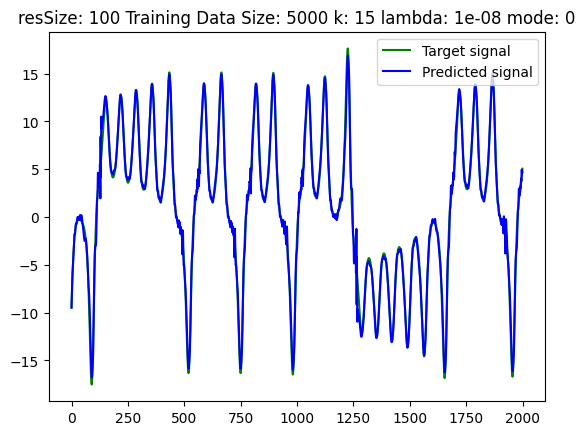

SOE:  84.72342788090783 MSE:  0.04236171394045392


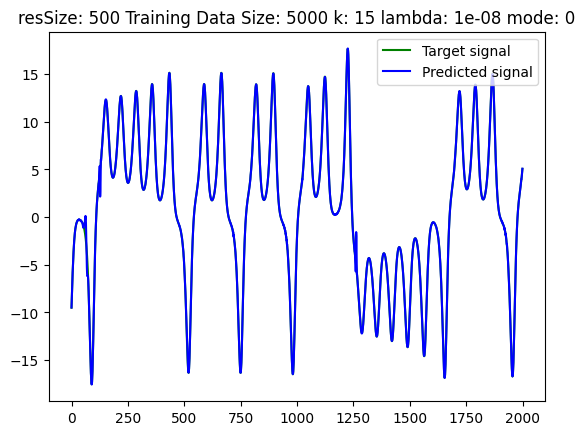

SOE:  47.66745082254755 MSE:  0.023833725411273776


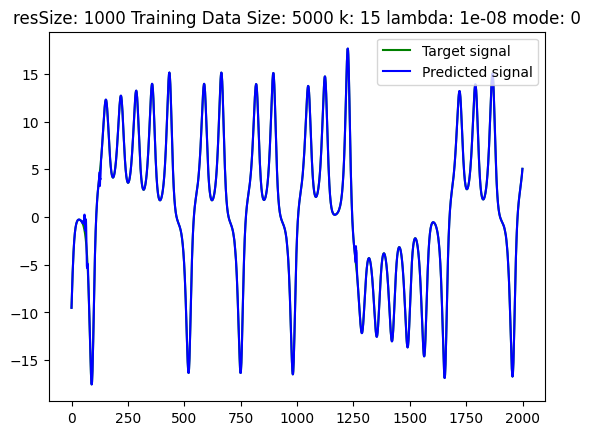

SOE:  1501.4037087166662 MSE:  0.7507018543583331


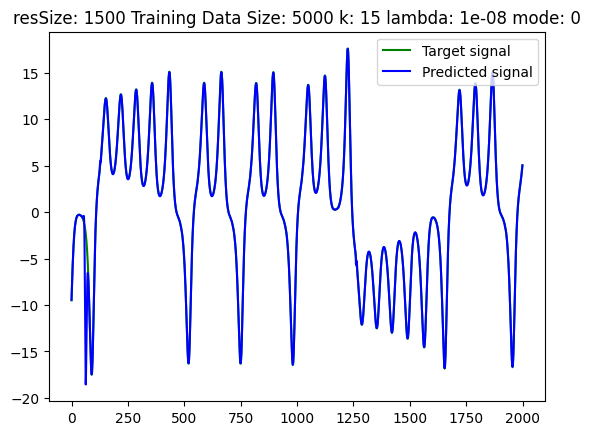

SOE:  1.4165818524424663 MSE:  0.0047219395081415545


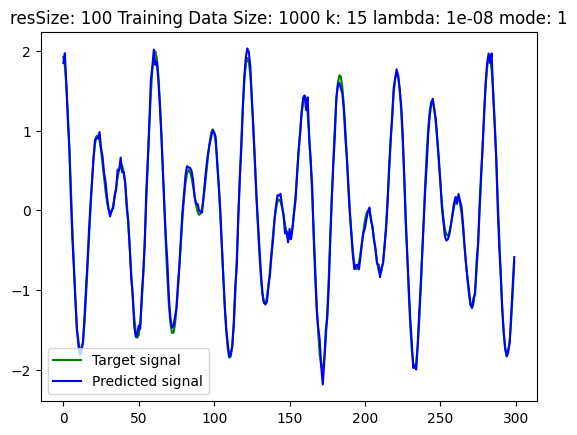

SOE:  0.6578377164088237 MSE:  0.0021927923880294123


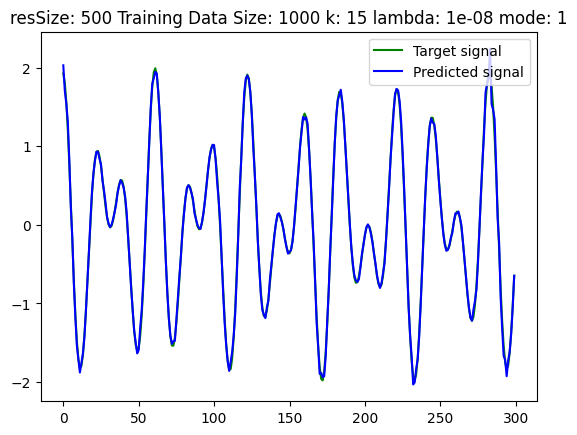

SOE:  0.07703432154712822 MSE:  0.00025678107182376073


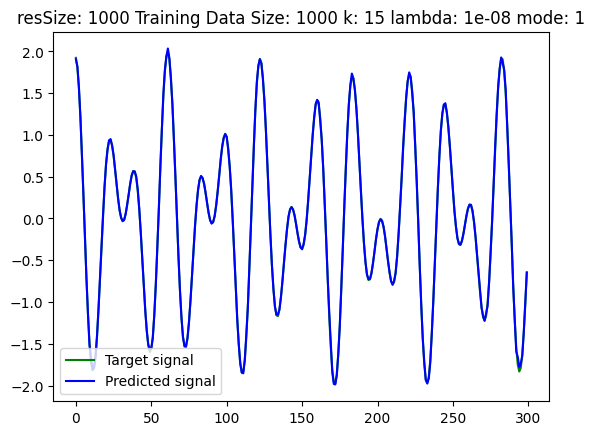

SOE:  0.09059021496352089 MSE:  0.0003019673832117363


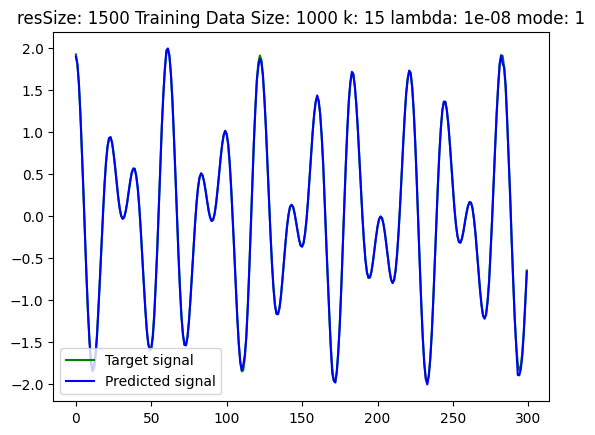

In [28]:
esn(100, 5000, 15, 1e-8, 0)
esn(500, 5000, 15, 1e-8, 0)
esn(1000, 5000, 15, 1e-8, 0)
esn(1500, 5000, 15, 1e-8, 0)


esn(100, 1000, 15, 1e-8, 1)
esn(500, 1000, 15, 1e-8, 1)
esn(1000, 1000, 15, 1e-8, 1)
esn(1500, 1000, 15, 1e-8, 1)


From example above, we can see that increasing reservior size will not always lower the error and it will increase the error at some point. 
It is because too few hidden units yields an inflexible network and poor generalization.
And too many hidden units leads to over-fitting and poor generalization. 

In the following, we will discuss the impact of the amount of training data used for optimizing the read-out weights

SOE:  27786.42099479315 MSE:  13.893210497396574


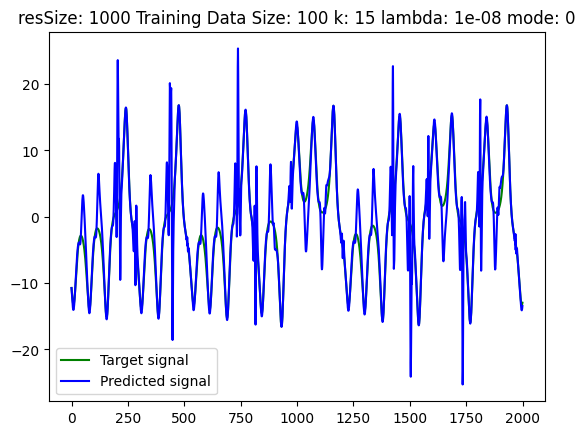

SOE:  1140274.961209295 MSE:  570.1374806046475


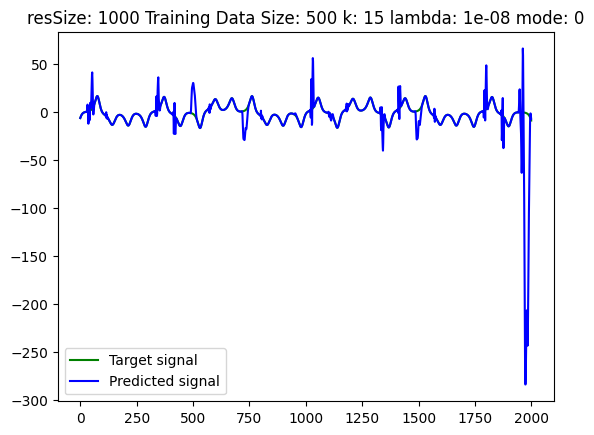

SOE:  1208862.6195897437 MSE:  604.4313097948718


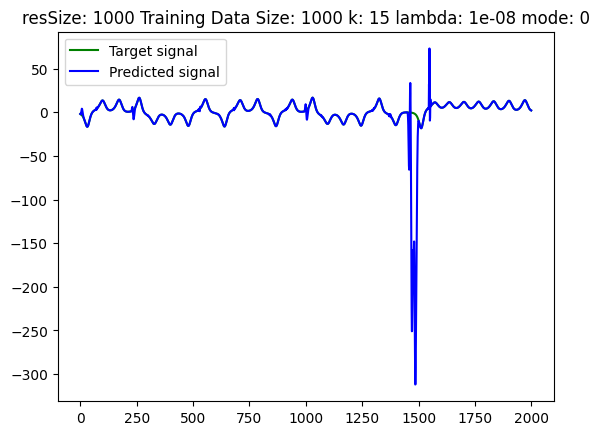

SOE:  47.66745082254755 MSE:  0.023833725411273776


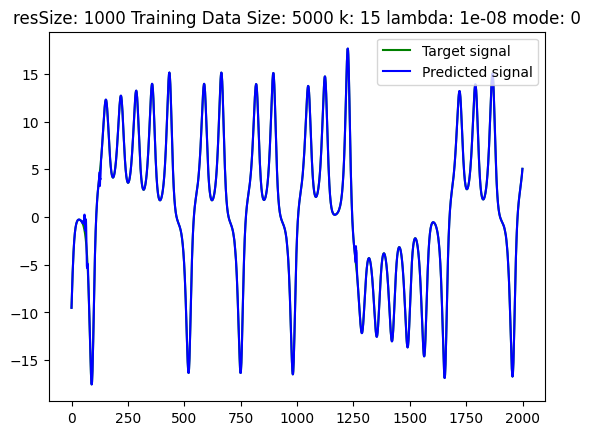

SOE:  713071.7899891699 MSE:  356.53589499458496


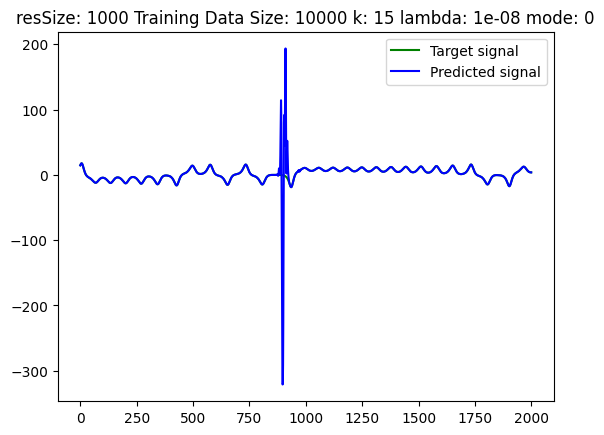

SOE:  21719.15447522054 MSE:  72.39718158406846


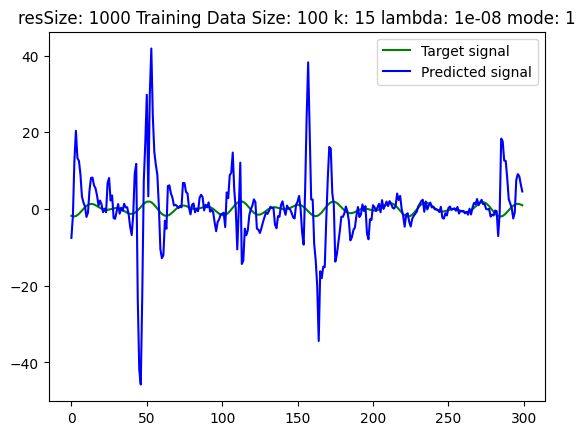

SOE:  2242.9493888765796 MSE:  7.476497962921932


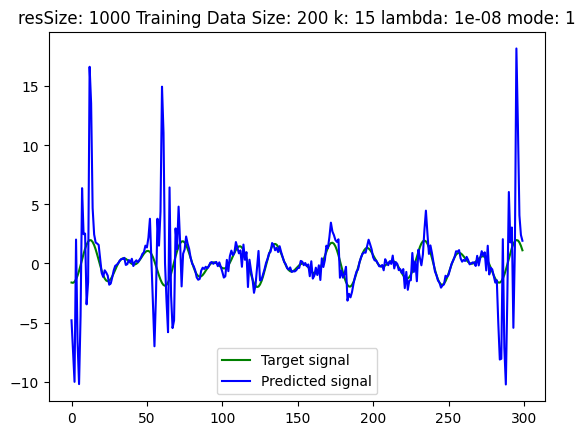

SOE:  5.362757389221168 MSE:  0.01787585796407056


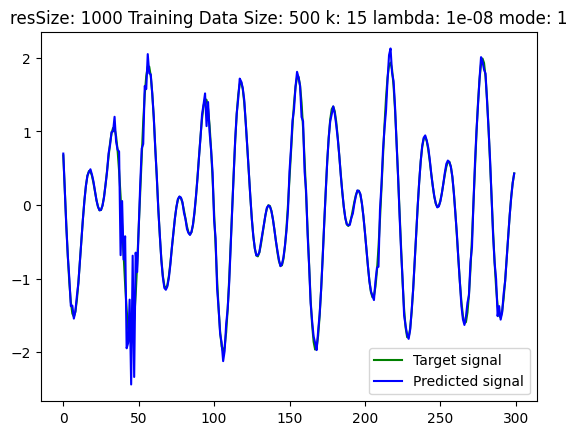

SOE:  0.07703432154712822 MSE:  0.00025678107182376073


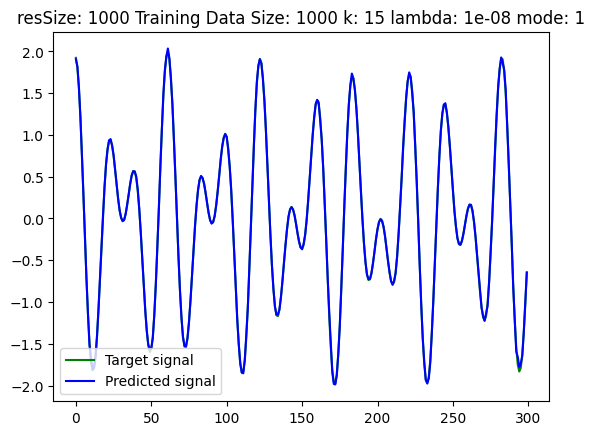

SOE:  0.051775453245099315 MSE:  0.00017258484415033106


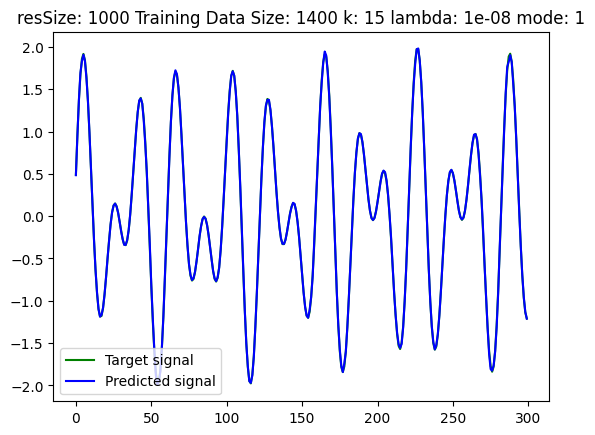

In [29]:
esn(1000, 100, 15, 1e-8, 0)
esn(1000, 500, 15, 1e-8, 0)
esn(1000, 1000, 15, 1e-8, 0)
esn(1000, 5000, 15, 1e-8, 0)
esn(1000, 10000, 15, 1e-8, 0)

esn(1000, 100, 15, 1e-8, 1)
esn(1000, 200, 15, 1e-8, 1)
esn(1000, 500, 15, 1e-8, 1)
esn(1000, 1000, 15, 1e-8, 1)
esn(1000, 1400, 15, 1e-8, 1)

From example above, we can see that adding more training data will be likey to decrease the error. 
However, from training data size 5000 to 10000 (graph 4 to graph 5) in mode 0(Lorenz), we can see the error greatly increase due to outlier. 
It is because too much data leads to noise and overfitting. But this problem can be solved with adjusting the regularization parameter of the ridge regression closed form solution.

In the following, I will use the ESN with training data size 10000, to show that how adjusting regularization parameter will mitigate sensitivity to noise and overfitting. 

SOE:  713071.7899891699 MSE:  356.53589499458496


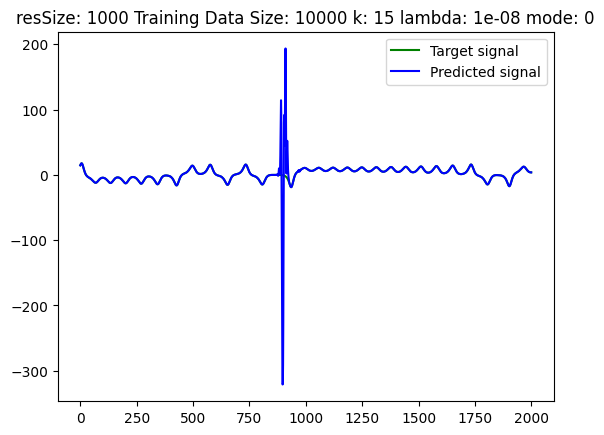

SOE:  20554.11519110129 MSE:  10.277057595550644


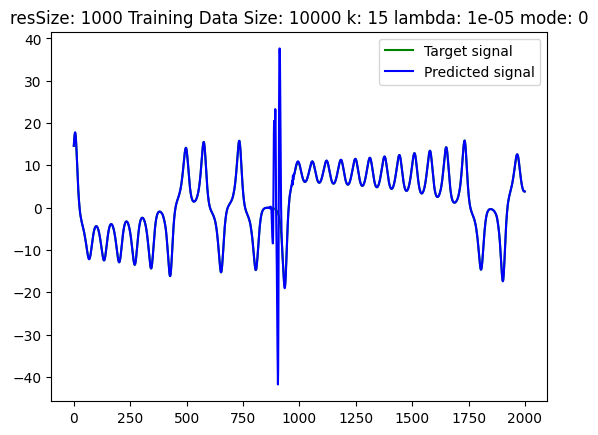

SOE:  4338.920353743276 MSE:  2.1694601768716377


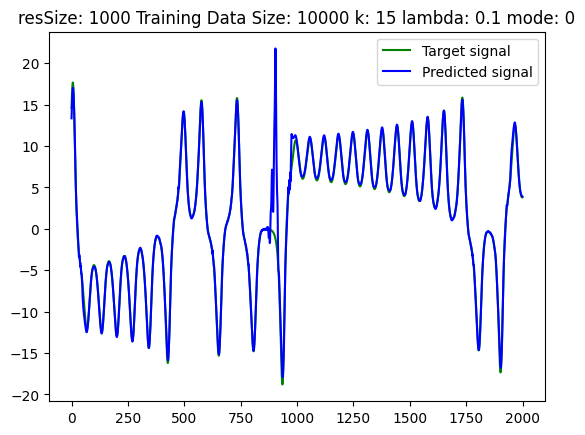

SOE:  1382.4473963833518 MSE:  0.691223698191676


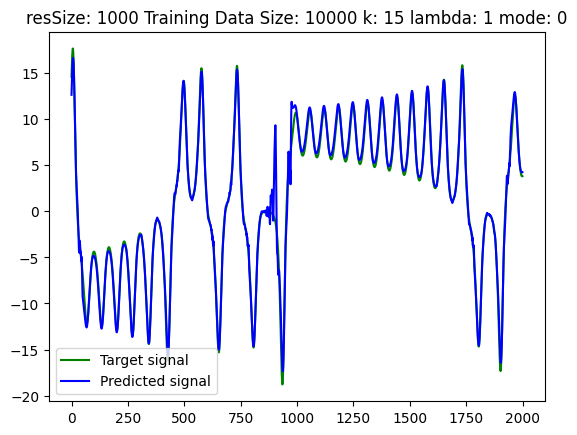

SOE:  1937.552825997011 MSE:  0.9687764129985055


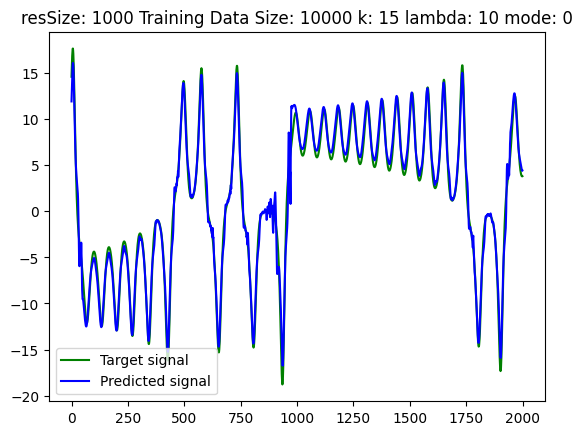

In [30]:
esn(1000, 10000, 15, 1e-8, 0)
esn(1000, 10000, 15, 1e-5, 0)
esn(1000, 10000, 15, 1e-1, 0)
esn(1000, 10000, 15, 1, 0)
esn(1000, 10000, 15, 10, 0)

From example above, we can see that the "sweet spot" of regularization parameter is "1" that it has the lowest error. 
With the larger regularization parameter, it reduce more the magnitude of the entries in w in the closed form solution of riddge regression. So it mitigate the sensitvity and overfitting. 
However, it might cause problem of underfitting when it is beyond the "Sweet spot" (lambda = 10, graph 5)

In the following , we will see the different forecasting horizon

SOE:  26.224603754827726 MSE:  0.013112301877413864


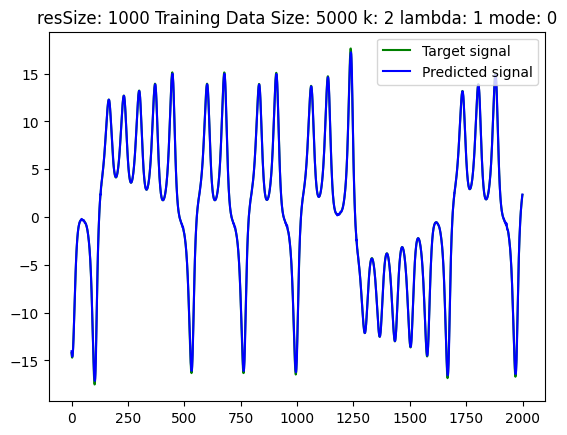

SOE:  155.86722395594919 MSE:  0.07793361197797459


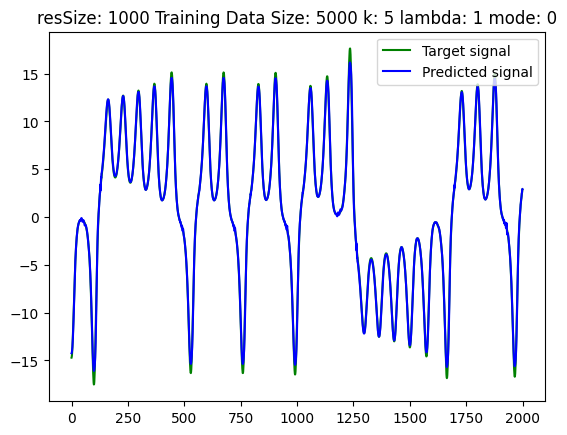

SOE:  405.3798268258257 MSE:  0.20268991341291287


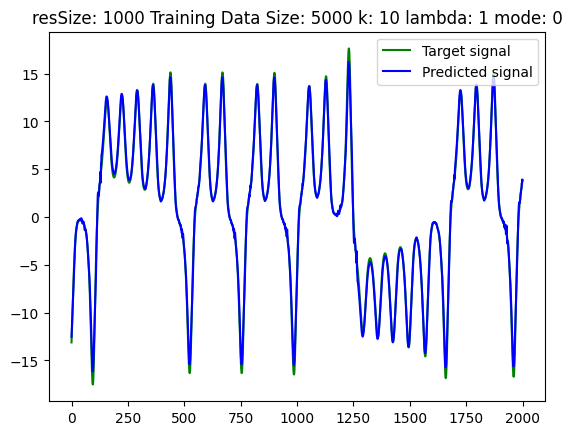

SOE:  526.427821271049 MSE:  0.26321391063552446


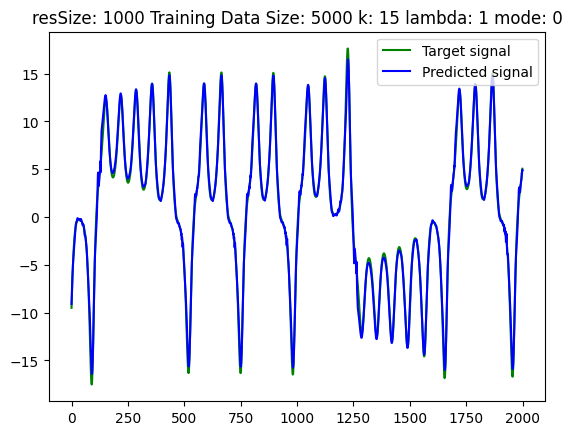

SOE:  4644.119867647112 MSE:  2.322059933823556


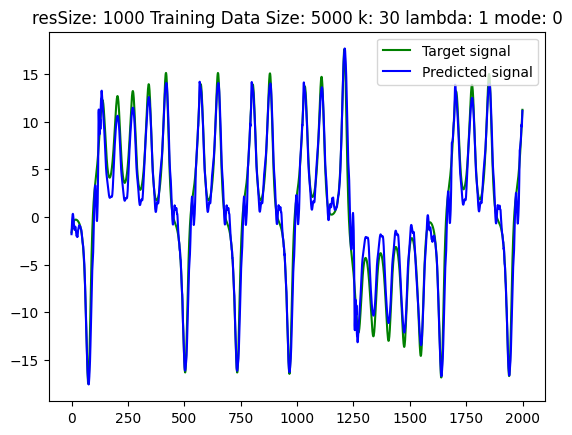

SOE:  37914.782407823805 MSE:  18.957391203911904


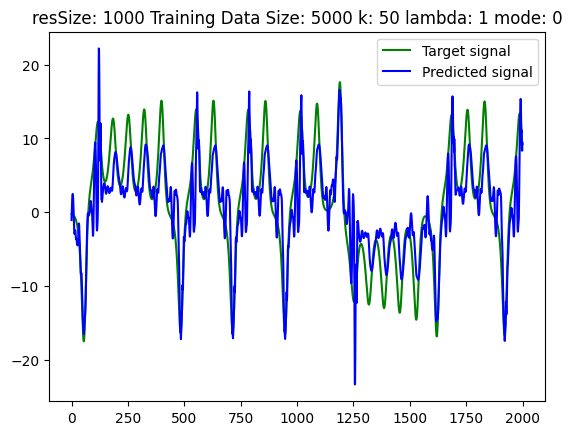

SOE:  71358.37208560617 MSE:  35.67918604280308


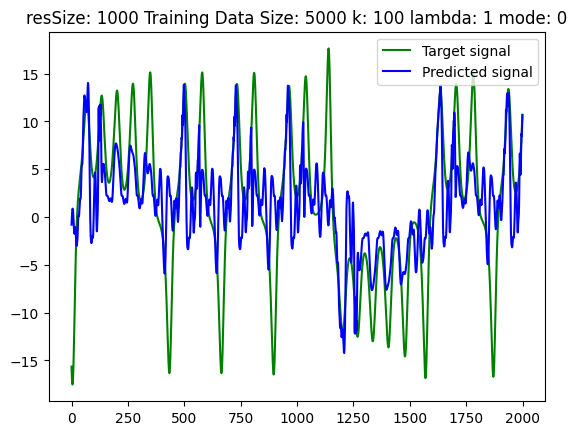

SOE:  111788.41329324729 MSE:  55.894206646623644


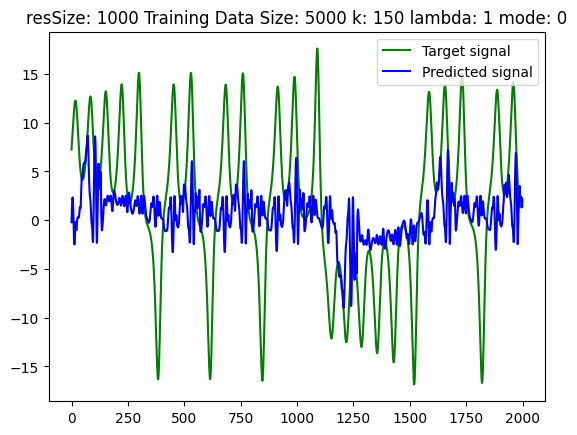

SOE:  0.05011271097080139 MSE:  0.0001670423699026713


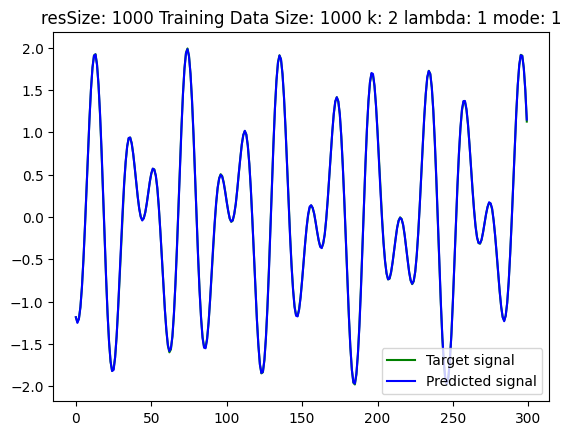

SOE:  0.764902479843103 MSE:  0.0025496749328103433


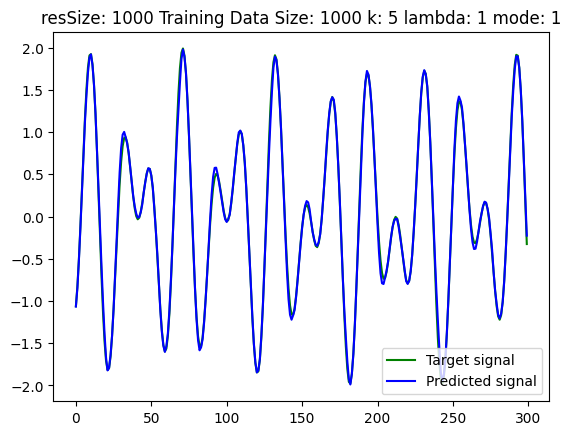

SOE:  3.0219795123086097 MSE:  0.0100732650410287


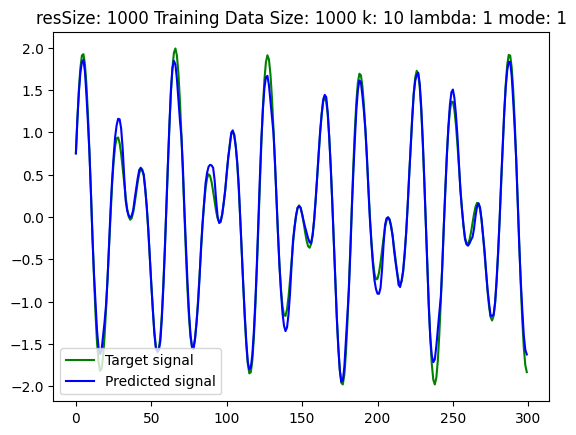

SOE:  0.9528270423229779 MSE:  0.003176090141076593


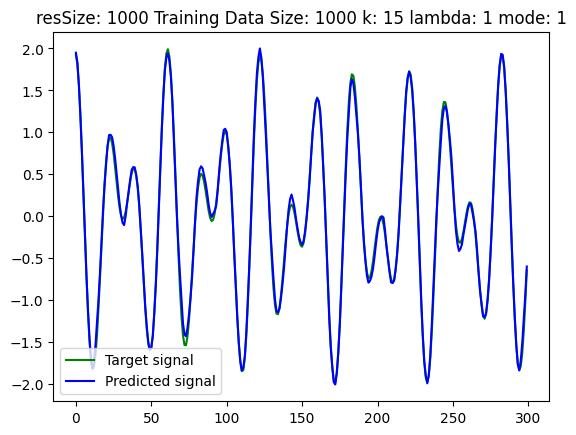

SOE:  2.7030826173703253 MSE:  0.009010275391234418


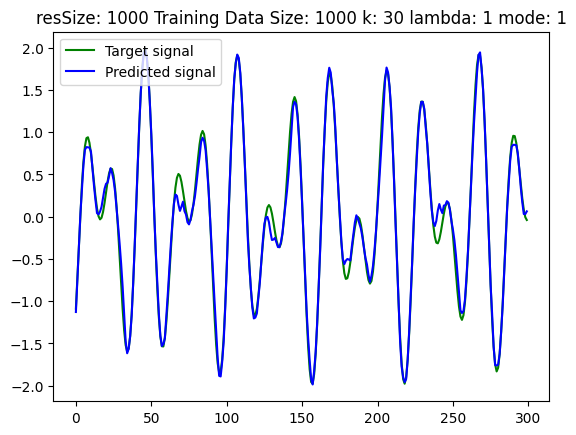

SOE:  0.7080582586603861 MSE:  0.00236019419553462


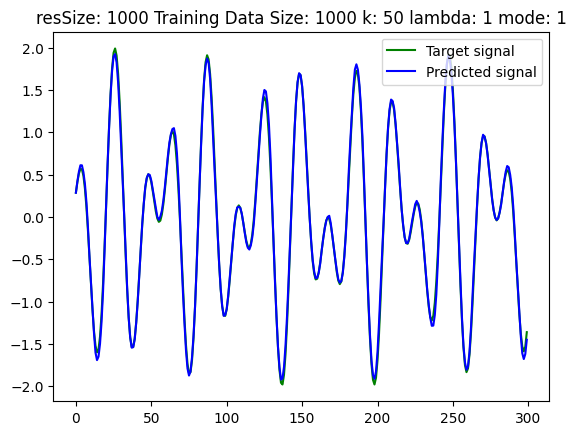

SOE:  1.731106017516284 MSE:  0.005770353391720947


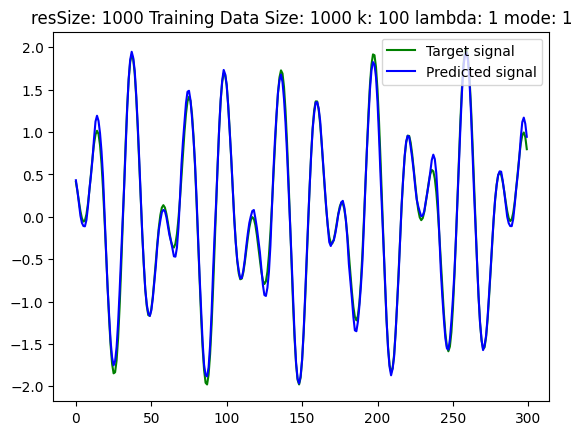

In [32]:
esn(1000, 5000, 2, 1, 0)
esn(1000, 5000, 5, 1, 0)
esn(1000, 5000, 10, 1, 0)
esn(1000, 5000, 15, 1, 0)
esn(1000, 5000, 30, 1, 0)
esn(1000, 5000, 50, 1, 0)
esn(1000, 5000, 100, 1, 0)
esn(1000, 5000, 150, 1, 0)

esn(1000, 1000, 2, 1, 1)
esn(1000, 1000, 5, 1, 1)
esn(1000, 1000, 10, 1, 1)
esn(1000, 1000, 15, 1, 1)
esn(1000, 1000, 30, 1, 1)
esn(1000, 1000, 50, 1, 1)
esn(1000, 1000, 100, 1, 1)

From example above, we can see that smaller k usually leads to lower error, because it is easier to predict. 
However, In mode 1 (2sin), we can see it get lower error in k = 50 than k =30, 
it is probably because 2sin has a similar pattern. But lorenz has a relatively different pattern so larger k will always get larger error.